In [1]:
%matplotlib inline

from qutip import *
from math import *

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image

# Model for two driven directly coupled qubits
In the notebook I will demonstrate a simulation of two qubits using a time dependant hamiltonian. Starting with a series of gates that will go back and forth to $|0\rangle$ to demonstrate the 1 qubit gates. 

Ending with another NOT gate on qubit 2, a Hadamard on qubit 1 and, the 2 qubit gate with a simple coupling, a CNOT2,1 (NOT on 2 controlled by 1). 
To get to finally the cat state: $|\Psi\rangle=\frac{1}{\sqrt 2}|01\rangle + \frac{1}{\sqrt 2}|10\rangle$

Based on:
https://nbviewer.ipython.org/github/jrjohansson/qutip-lectures/blob/master/Lecture-2A-Cavity-Qubit-Gates.ipynb

## Constants


In [2]:
N = 10


w1 = 3.0 * 2 * pi #qubit 1 angular freq
w2 = 2.0 * 2 * pi #qubit 2 angular freq

g = 0.01 * 2 * pi


Omega1=4
Omega2=4

tlist = np.linspace(0, 100, 500)

width = 0.5

#rotating wave approximation
use_rwa= False

## Operators

In [3]:
sm1 = tensor(destroy(2), qeye(2))

sz1 = tensor(sigmaz(), qeye(2))
sy1 = tensor(sigmay(), qeye(2))
sx1 = tensor(sigmax(), qeye(2))
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(2), destroy(2))

sz2 = tensor(qeye(2), sigmaz())
sy2 = tensor(qeye(2), sigmay())
sx2 = tensor(qeye(2), sigmax())
n2 = sm2.dag() * sm2


## Components of the Hamiltonian

In [5]:
# Hamiltonian using QuTiP

#qubits
H1 = - 0.5 * sz1 * w1
H2 = - 0.5 * sz2 * w2

#qubit drives
Hd1=Omega1*sy1
Hd2=Omega2*sy2

#Qubit coupling hamiltonian
# Hamiltonian
if use_rwa:
    Hqq = -g/2 * (sx1*sx2+sy1*xy2)
else:
    Hqq = -g * (sm1.dag() - sm1) * ( sm2.dag()-sm2)

H = H1 + H2 + Hd1+Hd2+Hqq

In [6]:
H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-15.70796327+0.j   0.        -4.j   0.        -4.j  -0.06283185+0.j]
 [  0.        +4.j  -3.14159265+0.j   0.06283185+0.j   0.        -4.j]
 [  0.        +4.j   0.06283185+0.j   3.14159265+0.j   0.        -4.j]
 [ -0.06283185+0.j   0.        +4.j   0.        +4.j  15.70796327+0.j]]

In [7]:
#unitary step function
def u_t(t):
    return 1*(t > 0)

We use Krantz's "A quantum engineer’s guide to superconducting qubits" page 28 to calculate the lenghts of the pulses:

The Drive voltage input is a sine wave with amplitude $V_0$ angular frenquency $\omega_d$, phase $\phi$ and $s(t)$ is a package envoltory that will be a rectangular function here:

$V_d(t) = V_0 s(t) \sin(\omega_d t+\phi)$ 

A $V_d$ pulse with $\omega_d$ angular frequency resonant to the target qubit frequency  makes an unitary transformation like this:

$U=e^{-i/2\Theta(t)(I\sigma_x+Q\sigma_y)}$ 

Where $I=\cos \phi$  is the in phase factor and $Q=\sin \phi$ is the out of phase factor. 

The angle $\Theta(t)$ which is the angle by which the qubit state is rotated is given by:

$\Theta(t) = -\Omega V_0 \int_0^ts(t^\prime)dt^\prime$ 

This equation can be used to tune the inputs like the amplitude $V_0$ and the integral of the envelope $s(t)$ which will be in our case the period of the rectangular function to obtain a desired angle like $\pi$.

By doing the drive voltage completely in phase or out of phase we get the following unitaries:

$U_{I=1, Q=0} = \cos(\frac{\Theta(t)}{2})+i\sin(\frac{\Theta(t)}{2})\sigma_x = (\Theta)_X$

$U_{I=0, Q=1} = \cos(\frac{\Theta(t)}{2})+i\sin(\frac{\Theta(t)}{2})\sigma_y= (\Theta)_Y$

The in phase turns the qubit $\Theta$ degrees on the x axis and so does the out of phase but on the y axis.

This can then be used to make the X (in phase $\pi$ degrees) and Y (out of phase $\pi$ degrees) gates:

$X =\sigma_x = i\sigma_x= U_{I=1, Q=0, \Theta=\pi} = (\pi)_X$

$Y =\sigma_y = i\sigma_y= U_{I=0, Q=1, \Theta=\pi}  = (\pi)_Y$

The $i$ is ignored because it's a global phase which can be ignored for not altering the results of measurements.

The Final Pauli gate the Z gate (a rotation on the qubit's Z axis) can be obtained by a combination of three gates where X means in phase (rotation around x axis) and Y out of phase pulses:

$\theta_Z = (\pi/2)_X \theta_Y (-\pi/2)_X= (\pi/2)_X \theta_Y (3\pi/2)_X$

This equation is from:
https://www.ucl.ac.uk/quantum-spins/sites/quantum-spins/files/paper90.pdf
page 1516 eq2

The bloch sphere below can aid in visualizing the rotations. The rotations follow the right hand rule with the thumb pointed to the positive direction in the axis:

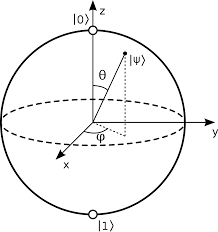

In [8]:
Image(filename='images/notebook-bloch-sphere.png') 

## Gate's pulses

In [257]:


#see krantz page 28 eq93 to calculate the lenghts of the pulses
#for s(t) being a retangular function
#Theta(t) = - Omega * V_0 * T_s

#single qubit X/NOT gate pulse
#V0 is the amplitude
#T0 is the start of the signal
#Omega is the constant of the drive interaction given for each qubit
#wd is the qubit angular frequency
#theta is the angle desired
def X_t(t ,V0 ,T0, Omega, wd,theta):
    T_s=theta/Omega/V0
    return V0*(u_t(t-T0)-u_t(t-T0-T_s))*sin(wd*t)

#single qubit Y gate pulse
def Y_t(t ,V0 ,T0, Omega, wd,theta):
    T_s=theta/Omega/V0
    return V0*(u_t(t-T0)-u_t(t-T0-T_s))*sin(wd*t+pi/2)

#single qubit Zpi/2 gate
# H = X_pi/2 * Y_pi/2* X3pi/2
def Z_t(t ,V0 ,T0, Omega, wd, theta):
    T_sx=3*pi/2/Omega/V0
    T_sy=theta/Omega/V0
    return X_t(t ,V0 ,T0, Omega, wd, 3*pi/2)+ Y_t(t ,V0 ,T0+1.1*T_sx, Omega, wd, theta)+X_t(t ,V0 ,T0+1.1*(T_sx+T_sy), Omega, wd, pi/2)

#single qubit Hadamard gate
# H = X_pi * Y_pi/2
def Had_t(t ,V0 ,T0, Omega, wd):
    T_sx=pi/1/Omega/V0
    return X_t(t ,V0 ,T0, Omega, wd, pi)+ Y_t(t ,V0 ,T0+1.2*T_sx, Omega, wd, pi/2)


## Single qubit demonstrative operations

We prepare our initial state with Qubit 1 in a superposition to make a cat state and qubit two in $|0\rangle$

Qubit 1: $H|0\rangle =1/\sqrt 2| 0 \rangle +1/\sqrt 2 | 1 \rangle$

Qubit 2: $X X H Z H |0\rangle = X|1\rangle = |0\rangle$

The process on qubit two serves to demostrate the importance of the phase of the qubit. After applying Z the superposition is changed to 
$|Q_2\rangle = 1/\sqrt 2|0\rangle - 1/\sqrt 2|1\rangle$

When applying the Hadamard instead of $|0\rangle$ that we would get from the state of Qubit 1 by reapplying a Hadamard gate ,which is an involutory operator $H=H^{-1}$ and $HH|0\rangle = |0\rangle$. We get $|1\rangle$. The X operator reverses all that traformation back to $|0\rangle$ and then another X back to $|1\rangle$ and are there to show another operation as well.

In [324]:
#qubit 1 drive
def wd1_t(t, args=None):
    return Had_t(t,0.3,10,Omega1,w1)

#qubit 2 drive
def wd2_t(t, args=None):
    return Had_t(t,0.3,5,Omega2,w2) + Z_t(t,0.3,12,Omega2,w2,pi) +Had_t(t,0.3,22,Omega2,w2)+ X_t(t,0.3,28,Omega2,w2,pi)+ X_t(t,0.3,32,Omega2,w2,pi)
 


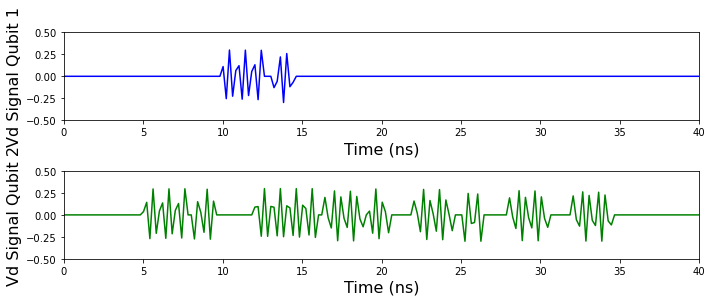

In [325]:
fig, axes = plt.subplots(2, 1, figsize=(10,4))
axes[0].plot(tlist, [wd1_t(t) for t in tlist], 'b', label="drive qubit1")
axes[1].plot(tlist, [wd2_t(t) for t in tlist], 'g', label="drive qubit2")
axes[0].set_ylim(-0.5,0.5)
axes[0].set_xlim(0,40)
axes[1].set_ylim(-0.5,0.5)
axes[1].set_xlim(0,40)

axes[0].set_xlabel("Time (ns)", fontsize=16)
axes[0].set_ylabel("Vd Signal Qubit 1", fontsize=16)
axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Vd Signal Qubit 2", fontsize=16)



fig.tight_layout()

Here we can see the many pulses on each qubit as a function of time. They would look more sine wave like if we had a simulation with more time steps. We use 500 steps in a hundred nanosecond simulation. 

Time evolution explained at: 
https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/landau-zener.ipynb

In [326]:

# method 2: a function callback that returns the coefficient for a qobj
    #H = [H0, [H1, lambda x,y: x]]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

#This will multiply Hd1 and Hd2 by the time dependant step functions like wd1_t during the mesolve step
H_t = [[Hd1, wd1_t],[Hd2, wd2_t], H1+H2]
# initial state: start with two qubits in ground state
psi0 = tensor(basis(2,0),basis(2,0))

res = mesolve(H_t, psi0, tlist, [], [])

In [327]:
 def single_qubit_graph(res):
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))

    axes.plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
    axes.plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
    axes.set_ylim(0, 1.5)
    #axes.set_xlim(0,100)

    axes.set_xlabel("Time (ns)", fontsize=16)
    axes.set_ylabel("Occupation probability", fontsize=16)
    axes.legend()

    fig.tight_layout()

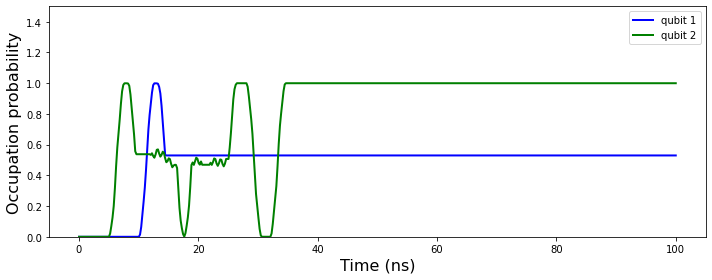

In [328]:
single_qubit_graph(res)

In [329]:
res.states[499].ptrace(1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.13483359e-04+0.j         6.63906053e-03-0.00833027j]
 [6.63906053e-03+0.00833027j 9.99886517e-01+0.j        ]]

In [330]:
wr=w1
splice=200
qubit=1

In [331]:


qstates=[]
for qstate in res.states[:splice]:
    qstates.append(qstate.ptrace([qubit]))

#np.multiply(qstates,np.exp(tlist[:200]*complex(0,-1)*w1))

In [332]:
x_list=expect(sigmax(),qstates)
y_list= expect(sigmay(),qstates)

x_list= np.multiply(x_list,np.cos(tlist[:splice]*(-wr)))+np.multiply(y_list,-np.sin(tlist[:splice]*(-wr)))
y_list= np.multiply(x_list,np.sin(tlist[:splice]*(-wr)))+np.multiply(y_list,np.cos(tlist[:splice]*(wr)))

z_list=expect(sigmaz(),qstates)

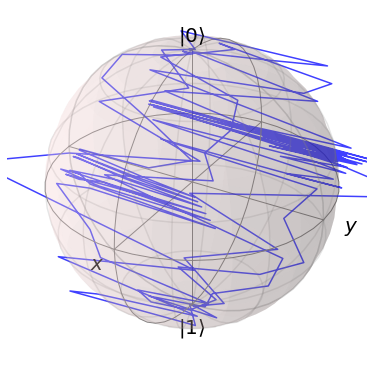

In [333]:
b = Bloch()
## add data points from expectation values ##
b.add_points([
            x_list,
            y_list,
            -z_list
             ], meth='l')


b.zlpos = [1.1,-1.2]

b.show()

Here you can visualize the two pulses acting in qubit 1 that form the Hadamard gate, a X (from zero to 1 expected value) and a $(\pi/2)_Y$, from 1 to 0.5 expected value, a superposition.

And the pulses in qubit 2. The first Hadamard like in the Qubit 1. The Z made of three other gates, you can notice a little wiggle when there is a rotation in an axis that the qubit is parallel to (x axis here). Then the qubit goes to zero and back to  the 0.5 expected value, this is the Y gate rotation. And does another longer wiggle around the 0.5 value, this is the $(3\pi/2)_X$ gate with a longer period. The last wiggle is from a X gate and it goes to 1 with another Y rotation. Then X makes it go from 1 to 0 expected qubit value.

# The CNOT gate
The CNOT gate can be build from two iSWAP gates and single qubit gates. Image from krantz page 32 IV-E-2 shown below:

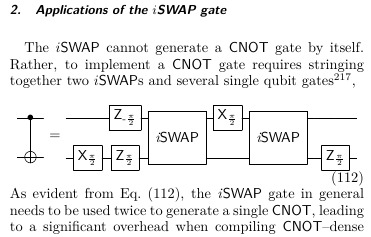

In [334]:
Image(filename='images/notebook-cnot.png') 

## Initial single gates
Here we do the initial single qubit gates before the first iSWAP

In [335]:
# initial state: use last state of the last simulation
psi1 = res.states[499]

In [336]:
psi1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.00398215-0.00612067j]
 [ 0.68265671-0.06581209j]
 [-0.00444292+0.00635796j]
 [-0.72624949+0.0457907j ]]

In [337]:
#qubit 1 drive
def wd1_t(t, args=None):
    return Z_t(t,0.3,5,Omega1,w1,pi/2)

#qubit 2 drive
def wd2_t(t, args=None):
    return X_t(t,0.3,5,Omega2,w2,pi/2) + Z_t(t,0.3,12,Omega2,w2,pi/2) 
 

H_t = [[Hd1, wd1_t],[Hd2, wd2_t], H1+H2]
# initial state: start with two qubits in ground state
res = mesolve(H_t, psi1, tlist, [], [])

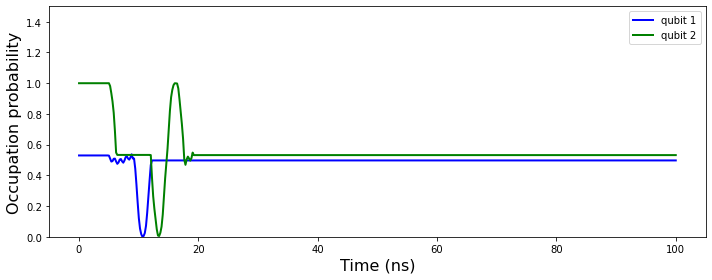

In [338]:
single_qubit_graph(res)

# The iSWAP gate
A 2-qubit XX+YY interaction. This is a Clifford and symmetric gate. Its action is to swap two qubit states and phase the |01⟩ and |10⟩ amplitudes by i.

It's made by doing a resonance of both qubits for a determined period. In the simulation I will just adjust the frequency of a qubit to match the other. But in practice this can be made by adjusting a magnetic flux going through the two qubits so that the frequency(dependant on the flux) adjusts to a value where both are equal. The period for the iSWAP is given by the formula:

$\tau = \frac{\pi}{2g}$

I will implement a special Hamiltonian for it to be used again later.


In [339]:
# initial state: use last state of the last simulation
psi2 = res.states[499]

In [340]:
psi2

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.48346316+0.03982433j]
 [ 0.5115429 -0.07628236j]
 [-0.01621292-0.4822129j ]
 [ 0.05105063+0.51164827j]]

In [341]:
# resonant iSWAP gate 2 qubits
T0 = 10
T_gate =pi/2/g

In [342]:
#qubit energy is changed to enter ressonance with other qubit in interval [T_0, T_0+T_gate]
def w1_t(t, args=None):
    return 1 + (w2/w1-1)*(u_t(t-T0)-u_t(t-T0-T_gate))



In [343]:
#This will multiply Hc H1 and H2 by the time dependant step functions like wc_t during the mesolve step
H_t_iSWAP = [ [H1, w1_t], Hqq+H2]

res = mesolve(H_t_iSWAP, psi2, tlist, [], [])

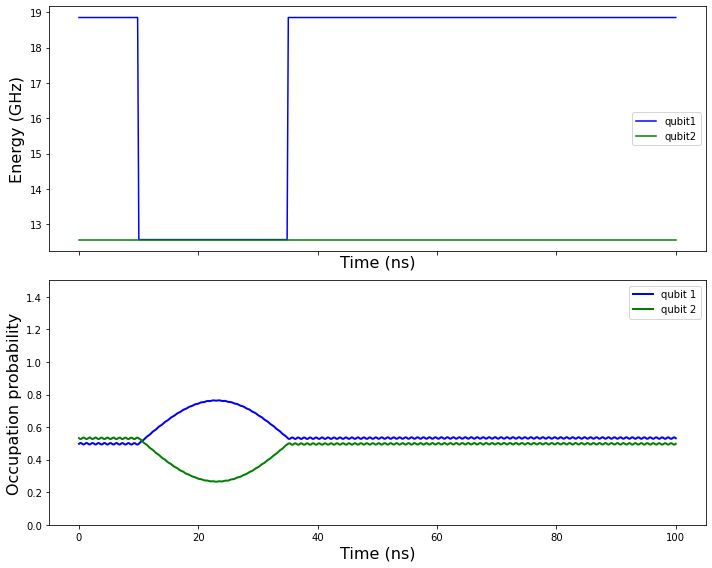

In [344]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,8))

axes[0].plot(tlist, [w1_t(t)*w1 for t in tlist], 'b', label="qubit1")
axes[0].plot(tlist, [w2 for t in tlist], 'g', label="qubit2")
#axes.set_ylim(-0.6,0.6)
#axes.set_xlim(0,100)

axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].set_xlabel("Time (ns)", fontsize=16)
axes[0].legend()

axes[0].legend()

axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1.5)
#axes[1].set_xlim(0,20)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()


fig.tight_layout()

You can see in the energy graph how a resonance is necessary for the interaction visible in the occupation probability graph where the cavity and qubit exchange their states. First with qubit 1 and then with qubit 2.

## $X_\pi/2$ in between gate

In [345]:
# initial state: use last state of the last simulation
psi3 = res.states[499]

In [346]:
psi3

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.48397273-3.25520121e-02j]
 [ 0.48303471+4.21147278e-04j]
 [ 0.09393562+5.08212513e-01j]
 [-0.05872427-5.10720714e-01j]]

In [347]:
#qubit 1 drive
def wd1_t(t, args=None):
    return X_t(t,0.3,5,Omega1,w1,pi/2)

#qubit 2 drive
def wd2_t(t, args=None):
    return 0

H_t = [[Hd1, wd1_t],[Hd2, wd2_t], H1+H2]

res = mesolve(H_t, psi3, tlist, [], [])

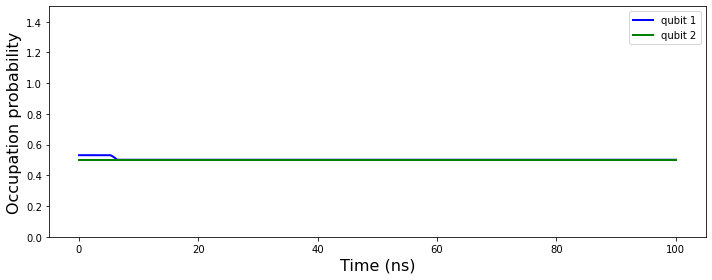

In [348]:
single_qubit_graph(res)

## Second iSWAP

In [349]:
# initial state: use last state of the last simulation
psi4 = res.states[499]

In [350]:
psi4

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.02518834+0.05660504j]
 [ 0.70280163-0.02511277j]
 [ 0.10610009+0.69806716j]
 [-0.0544185 -0.00917975j]]

In [351]:
res = mesolve(H_t_iSWAP, psi4, tlist, [], [])

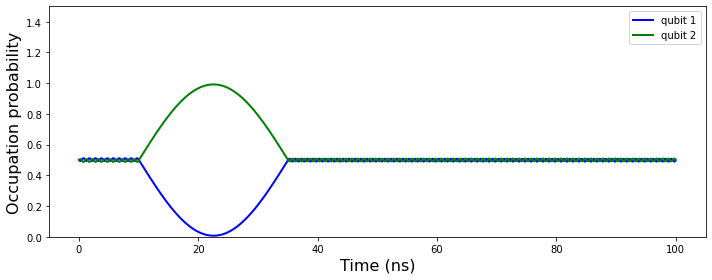

In [352]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))


axes.plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes.plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes.set_ylim(0, 1.5)
#axes[1].set_xlim(0,20)

axes.set_xlabel("Time (ns)", fontsize=16)
axes.set_ylabel("Occupation probability", fontsize=16)
axes.legend()


fig.tight_layout()

## $Z_\pi/2$ final gate

In [353]:
# initial state: use last state of the last simulation
psi5 = res.states[499]

In [354]:
#qubit 1 drive
def wd1_t(t, args=None):
    return 0

#qubit 2 drive
def wd2_t(t, args=None):
    return Z_t(t,0.3,5,Omega2,w2,pi/2)

H_t = [[Hd1, wd1_t],[Hd2, wd2_t], H1+H2]

res = mesolve(H_t, psi5, tlist, [], [])

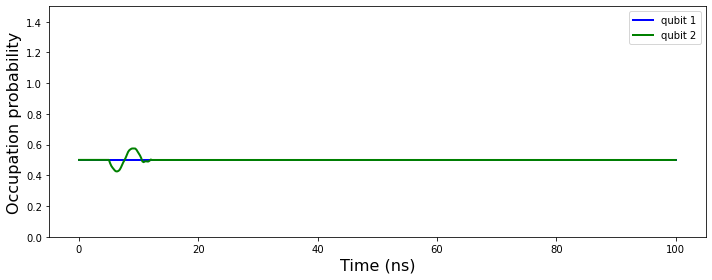

In [355]:
single_qubit_graph(res)

In [356]:
final=res.states[499]

## Final answer density matrix of the qubits

The answer expected for the problem was the density matrix:

$\rho = 0.5|01\rangle\langle01|+0.5|10\rangle\langle10|$

Because we did a CNOT with the controller qubit at a Hadamard Superposition and the controlled at $|1\rangle$

$CNOT_{1,2}X_2H_1 |0_20_1\rangle = CNOT_{1,2}|1_2\rangle(\frac{1}{\sqrt 2}|0_1\rangle + \frac{1}{\sqrt 2}|1_1\rangle) =  \frac{1}{\sqrt 2}|01\rangle + \frac{1}{\sqrt 2}|10\rangle$

Which has the density matrix above $\rho$ explicit below.

In [357]:
0.5*(tensor(basis(2,1),basis(2,0))*tensor(basis(2,1),basis(2,0)).dag()+tensor(basis(2,0),basis(2,1))*tensor(basis(2,0),basis(2,1)).dag())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0. ]]

$|0_10_2\rangle |0_11_2\rangle |1_10_2\rangle |1_11_2\rangle$

We get a density matrix as the final answer because we do the partial trace on the cavity states to eliminate them from our answer and visualize only the qubits.

In [358]:
rho=final*final.dag()
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.00482576+0.j         -0.03706122-0.03198609j -0.03862134-0.02995611j
   0.00399051+0.00096425j]
 [-0.03706122+0.03198609j  0.4966353 +0.j          0.49516173-0.02593073j
  -0.03703783+0.01904452j]
 [-0.03862134+0.02995611j  0.49516173+0.02593073j  0.49504644+0.j
  -0.0379223 +0.01705416j]
 [ 0.00399051-0.00096425j -0.03703783-0.01904452j -0.0379223 -0.01705416j
   0.00349249+0.j        ]]